In [1]:
import os
import torch

torch.manual_seed(53)
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_geometric


DEPRECATION: Loading egg at /home/csl-stu/.pyenv/versions/3.12.2/envs/2121057/lib/python3.12/site-packages/h5py-3.12.1-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rxbu3pvm did not run successfully.
  │ exit code: 128
  ╰─> [1 lines of output]
      fatal: unable to access 'https://github.com/pyg-team/pytorch_geometric.git/': Failed to connect to 133.78.130.254 port 8081 after 0 ms: 接続を拒否されました
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rxbu3pvm did not run succ

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"


In [7]:
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
from rosenbrock_nn_similarity import dim_num_dataset

class GridDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super().__init__('.', transform)  # 親クラスの初期化を明示的に呼び出し

        # データを取得
        embeddings, edges, edge_attr, ys = dim_num_dataset(dim_valuem=1)

        # torch.Tensor に変換
        embeddings = torch.tensor(embeddings, dtype=torch.float)
        edges = torch.tensor(edges, dtype=torch.long).T  # 転置して [2, num_edges] の形状に
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        ys = torch.tensor(ys, dtype=torch.float)

        # Dataオブジェクトを生成
        data = Data(x=embeddings, edge_index=edges, y=ys, edge_attr=edge_attr)
        self.edge_attr = edge_attr
        # self.collate を使ってデータセット形式に変換
        self.data, self.slices = self.collate([data])
        self.data.num_nodes = len(embeddings)

    def layout(self):
        return {i: x.detach().numpy() for i, x in enumerate(self.data.x)}

    def node_color(self):
        c = {0: "red", 1: "blue"}
        return [c[int(x.detach().numpy())] for (i, x) in enumerate(self.data.y)]


In [8]:
use_dataset = GridDataset()
# use_dataset = ColonyDataset


/tmp/ipykernel_984643/1514163239.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embeddings, dtype=torch.float)
/tmp/ipykernel_984643/1514163239.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edges, dtype=torch.long).T  # 転置して [2, num_edges] の形状に
/tmp/ipykernel_984643/1514163239.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(ys, dtype=torch.float)
/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300

In [9]:
dataset = use_dataset
data = dataset
print(f"edge_index shape: {data.edge_attr.shape}")
data.edge_index = data.edge_index.T

data = torch_geometric.utils.train_test_split_edges(data)


edge_index shape: torch.Size([30])


/home/csl-stu/.pyenv/versions/2121057/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [10]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(
            in_channels, 4 * out_channels, cached=True
            ) 
        self.conv1b = torch_geometric.nn.GCNConv(
            4 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1c = torch_geometric.nn.GCNConv(
            16 * out_channels, 32 * out_channels, cached=True
            ) 
        self.conv1d = torch_geometric.nn.GCNConv(
            32 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1e = torch_geometric.nn.GCNConv(
            16 * out_channels, 4 * out_channels, cached=True
            ) 
        self.conv2 = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            ) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv1b(x, edge_index).relu()
        x = self.conv1c(x, edge_index).relu()
        x = self.conv1d(x, edge_index).relu()
        x = self.conv1e(x, edge_index).relu()
        return self.conv2(x, edge_index)


In [11]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [12]:
epochs = 500
out_channels = 16

num_features = 35
model = torch_geometric.nn.GAE(GCNEncoder(num_features, out_channels))
model = model.to(device)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [13]:
import copy

loss_hist = []
auc_hist = []
ap_hist = []
best_score = None
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    loss_hist.append(loss)
    auc_hist.append(auc)
    ap_hist.append(ap)
    if best_score is None or best_score < ap:
        best_score = ap
        best_model = copy.deepcopy(model)
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}, Loss: {}'.format(epoch, auc, ap, loss))


Epoch: 001, AUC: 0.0000, AP: 0.3833, Loss: 1.3871502876281738
Epoch: 003, AUC: 0.8889, AP: 0.9167, Loss: 1.3879698514938354
Epoch: 004, AUC: 1.0000, AP: 1.0000, Loss: 1.384006142616272


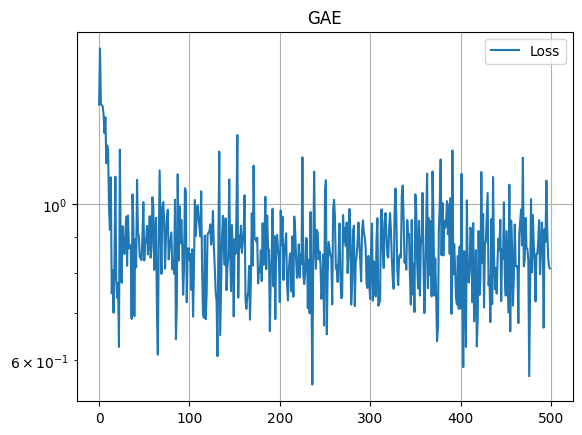

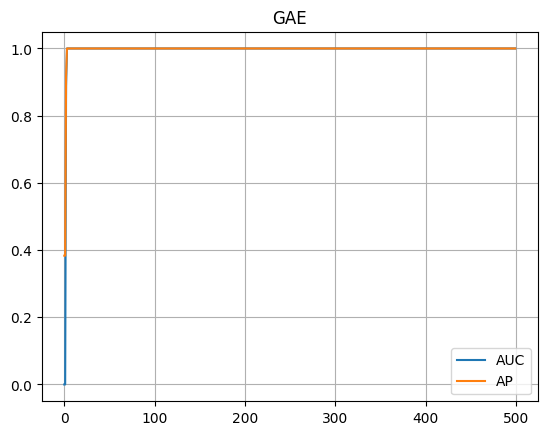

In [14]:
import matplotlib.pyplot as plt

plt.title("GAE")
plt.plot(loss_hist, label="Loss")
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()
plt.title("GAE")
plt.plot(auc_hist, label="AUC")
plt.plot(ap_hist, label="AP")
plt.grid()
plt.legend()
plt.show()


In [15]:
z = best_model.encode(x, train_pos_edge_index)
prob_adj = z @ z.T
prob_adj = prob_adj - torch.diagonal(prob_adj)
prob_adj


tensor([[ 0.0000e+00, -2.3721e-03, -7.7663e-05,  ..., -8.8491e-03,
         -2.1370e-02, -1.3417e-02],
        [ 1.8300e-03,  0.0000e+00,  1.8485e-03,  ..., -5.8878e-03,
         -1.7628e-02, -1.0140e-02],
        [-9.8534e-06, -2.2858e-03,  0.0000e+00,  ..., -8.7581e-03,
         -2.1269e-02, -1.3325e-02],
        ...,
        [ 6.0676e-03,  4.8268e-03,  6.0908e-03,  ...,  0.0000e+00,
         -1.0276e-02, -3.6584e-03],
        [ 1.2047e-02,  1.1588e-02,  1.2081e-02,  ...,  8.2252e-03,
          0.0000e+00,  5.3975e-03],
        [ 8.4795e-03,  7.5547e-03,  8.5038e-03,  ...,  3.3213e-03,
         -6.1239e-03,  0.0000e+00]], grad_fn=<SubBackward0>)

In [16]:
prob_adj_values = prob_adj.detach().cpu().numpy().flatten()
prob_adj_values.sort()
dataset = use_dataset()
threshold = prob_adj_values[-len(dataset.data.edge_attr)]
dataset.data.edge_index = (prob_adj >= threshold).nonzero(as_tuple=False).t()


TypeError: 'GridDataset' object is not callable

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())


# Variable Auto Encoder

In [ ]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(
            in_channels, 4 * out_channels, cached=True
            ) 
        self.conv1b = torch_geometric.nn.GCNConv(
            4 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1c = torch_geometric.nn.GCNConv(
            16 * out_channels, 32 * out_channels, cached=True
            ) 
        self.conv1d = torch_geometric.nn.GCNConv(
            32 * out_channels, 16 * out_channels, cached=True
            ) 
        self.conv1e = torch_geometric.nn.GCNConv(
            16 * out_channels, 4 * out_channels, cached=True
            ) 
        self.conv_mu = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            )
        self.conv_logstd = torch_geometric.nn.GCNConv(
            4 * out_channels, out_channels, cached=True
            )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv1b(x, edge_index).relu()
        x = self.conv1c(x, edge_index).relu()
        x = self.conv1d(x, edge_index).relu()
        x = self.conv1e(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [ ]:
epochs = 500
out_channels = 16

num_features = dataset.num_features
model = torch_geometric.nn.VGAE(
    VariationalGCNEncoder(num_features, out_channels)
    )
model = model.to(device)

x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
import copy

loss_hist = []
auc_hist = []
ap_hist = []
best_score = None
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    loss_hist.append(loss)
    auc_hist.append(auc)
    ap_hist.append(ap)
    if best_score is None or best_score < ap:
        best_score = ap
        best_model = copy.deepcopy(model)
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}, Loss: {}'.format(epoch, auc, ap, loss))


In [ ]:
import matplotlib.pyplot as plt

plt.title("VGAE")
plt.plot(loss_hist, label="Loss")
plt.grid()
plt.legend()
plt.yscale('log')
plt.show()
plt.title("VGAE")
plt.plot(auc_hist, label="AUC")
plt.plot(ap_hist, label="AP")
plt.grid()
plt.legend()
plt.show()


In [ ]:
z = best_model.encode(x, train_pos_edge_index)
prob_adj = z @ z.T
prob_adj = prob_adj - torch.diagonal(prob_adj)
prob_adj


In [ ]:
prob_adj_values = prob_adj.detach().cpu().numpy().flatten()
prob_adj_values.sort()
dataset = use_dataset()
threshold = prob_adj_values[-len(dataset.data.edge_attr)]
dataset.data.edge_index = (prob_adj >= threshold).nonzero(as_tuple=False).t()


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = torch_geometric.utils.convert.to_networkx(dataset.data)
plt.figure(figsize=(12,12))
nx.draw_networkx(G, pos=dataset.layout(), with_labels=False, alpha=0.5, node_color=dataset.node_color())
